*A notebook on a naive shrinkage correction approach where we just run PCA holding 1 single sample at a time for every sample ...*

# Imports

In [152]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pandas as pd

import pcshrink

# Functions

In [2]:
def holdout_pca(z, Z, K):
    """
    """
    n = Z.shape[1]
    pca = PCA(K)
    pca.fit(Z.T)
    F_hat = pca.components_.T
    
    l = (F_hat.T @ z)

    return(l)

# Data prep

In [3]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 8.19 s, sys: 2.67 s, total: 10.9 s
Wall time: 7.92 s


In [6]:
print(data.n, data.p)

777 594924


Find snps that are too rare or too common

In [7]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(data.Y, axis=1)) / (2 + (2. * data.n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [8]:
Z = data.Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

Text(0,0.5,'Emprical Std')

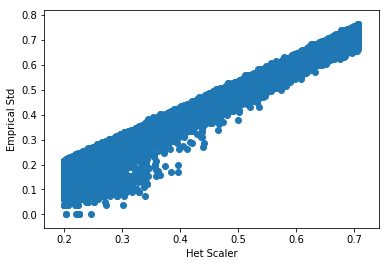

In [9]:
plt.scatter(het, std)
plt.xlabel("Het Scaler")
plt.ylabel("Emprical Std")

# PCA

In [16]:
%%time
pca = PCA(data.n, svd_solver="full")
pca.fit(Z.T)

CPU times: user 2min 42s, sys: 15.3 s, total: 2min 57s
Wall time: 9.18 s


snp weights

In [17]:
F_hat = pca.components_.T
F_hat.shape

(426765, 777)

coordinates 

In [18]:
L = (F_hat.T @ Z).T 
#L = L / np.linalg.norm(L, axis=0, ord=2)

Plot PC1 vs PC2

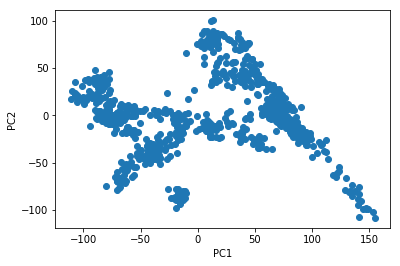

In [19]:
plt.scatter(L[:, 0], -L[:, 1])
plt.xlabel("PC1");
plt.ylabel("PC2");

In [15]:
%%time

K = 10
q = data.n
L_proj = np.empty((q, K))

for i in range(q):
    
    print(i)
    
    idx = np.ones(data.n, dtype="bool")
    idx[i] = False
    
    z = Z[:, i]
    Z_train = Z[:, idx]
    
    L_proj[i, :] = holdout_pca(z, Z_train, K)
    
#np.save("data/L_proj", L_proj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#L_proj = L_proj / np.linalg.norm(L_proj, axis=0, ord=2)

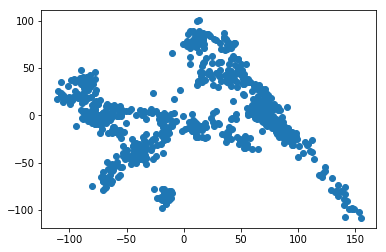

In [24]:
plt.scatter(L[:, 0], -L[:,1])

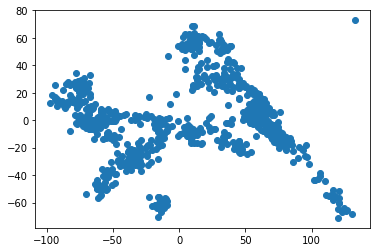

In [26]:
plt.scatter(L_proj[:, 0], -L_proj[:, 1])

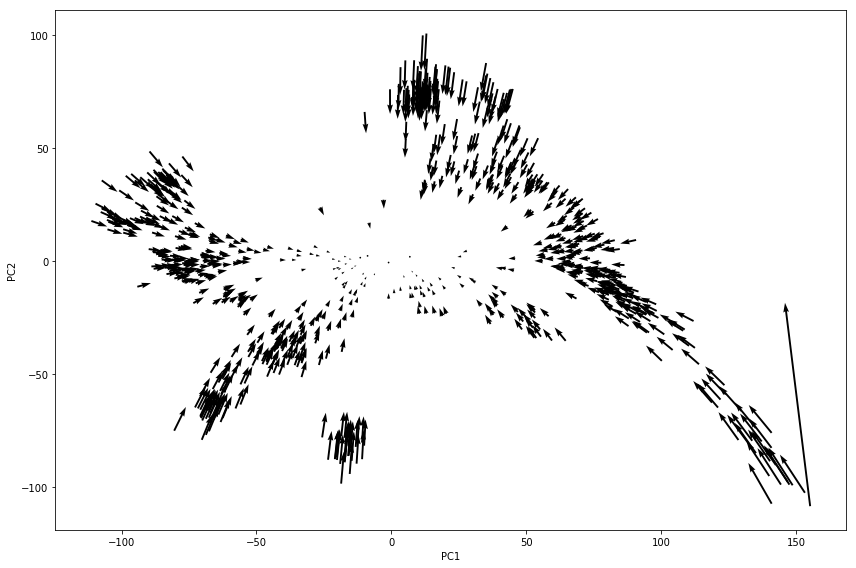

In [194]:
plt.figure(figsize=(12, 8))
#plt.quiver(L_proj[0,0], -L_proj[0,1], L[0,0], -L[0,1],)
plt.quiver(L[:,0], -L[:,1], L_proj[:,0]-L[:,0], -(L_proj[:,1]-L[:,1]))

plt.xlabel("PC1");
plt.ylabel("PC2");
plt.tight_layout()

Text(0,0.5,'PC2')

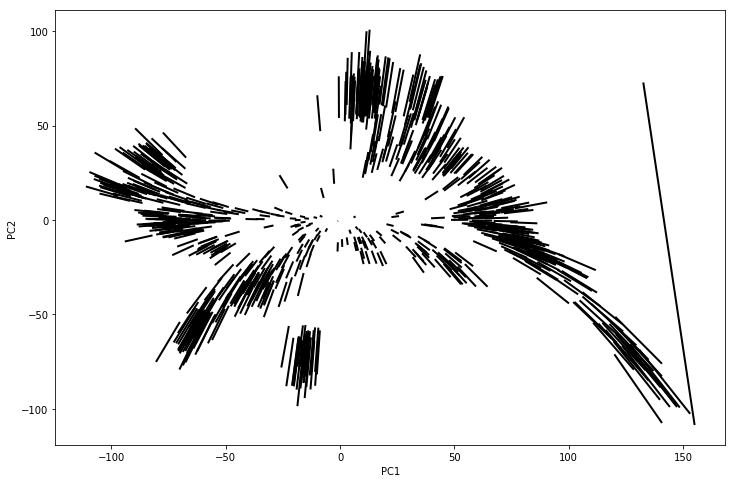

In [183]:
#plt.quiver(X=L[:,0], Y=-L[:,1], U=L_proj[:,0], V=-L_proj[:,1])
#plt.xlabel("PC1");
#plt.ylabel("PC2");

lines = []
for i in range(L.shape[0]):
    lines.append([(L[i, 0], -L[i, 1]), (L_proj[i, 0], -L_proj[i, 1])])
    
lc = mc.LineCollection(lines, linewidths=2, colors="black")
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(lc)
ax.autoscale()

plt.xlabel("PC1")
plt.ylabel("PC2")